In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import string
import ast
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import string

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
nltk.download('omw-1.4')
stopwords = set(stopwords.words("english"))

import pyLDAvis.sklearn
import math
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sruja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is alr

In [2]:
tweetDf = pd.read_csv('data123.csv')

In [3]:
tweetDf.shape

(20002, 11)

In [4]:
tweetDf['Date'] = pd.to_datetime(tweetDf['Date'], format= '%Y-%m-%d %H:%M:%S')

In [5]:
tweetDf.sort_values(by='Date', inplace=True)

In [6]:

# Delete duplicate rows based on specific columns 
tweetDf = tweetDf.drop_duplicates(subset=["Tweet"], keep="last")


In [7]:
tweetDf.shape

(16418, 11)

In [8]:
tweetDf['Location'].isnull().sum()  # returns 2

1537

In [9]:
tweetDf['Tweet'] = tweetDf['Tweet'].str.lower()
tweetDf['Hashtags'] = tweetDf['Hashtags'].str.lower()
tweetDf['Hashtags'] = tweetDf['Hashtags'].replace(np.nan,'no hashtags')
tweetDf['Location'] = tweetDf['Location'].replace(np.nan,'US,US')
tweetDf['Mentioned User'] = tweetDf['Mentioned User'].replace(np.nan,'no mentions')

In [10]:
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'bammer'], inplace=True)
tweetDf.shape

(16407, 11)

In [11]:
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'bomb'], inplace=True)
tweetDf.shape

(12359, 11)

In [12]:
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'blunt'], inplace=True)
tweetDf.shape

(9858, 11)

In [13]:
tweetDf.drop(tweetDf.index[tweetDf['Key Word'] == 'dope'], inplace=True)
tweetDf.shape

(3284, 11)

In [14]:
start_date = '2022-10-06 19:00:00'
end_date = '2022-10-06 19:53:00'
# Select DataFrame rows between two dates
mask = (tweetDf['Date'] > start_date) 
afterDf = tweetDf.loc[mask]
afterDf.shape

(558, 11)

In [15]:
start_date = '2022-10-06 18:59:59'
# Select DataFrame rows between two dates
mask = (tweetDf['Date'] < start_date) 
beforeDf = tweetDf.loc[mask]
beforeDf.shape

(2726, 11)

In [16]:
tweetDf = tweetDf.reset_index(drop=True)

In [17]:
tweetDf.shape

(3284, 11)

In [18]:
def hashtags(text):
    
    hashtag = []  
    for i in text:
        if i != 'no hashtags':

            for j in ast.literal_eval(i):
                hashtag.append(j)
    return hashtag

In [19]:
hashtag = hashtags(tweetDf['Hashtags'])

In [20]:
hashtag = {x:hashtag.count(x) for x in hashtag}

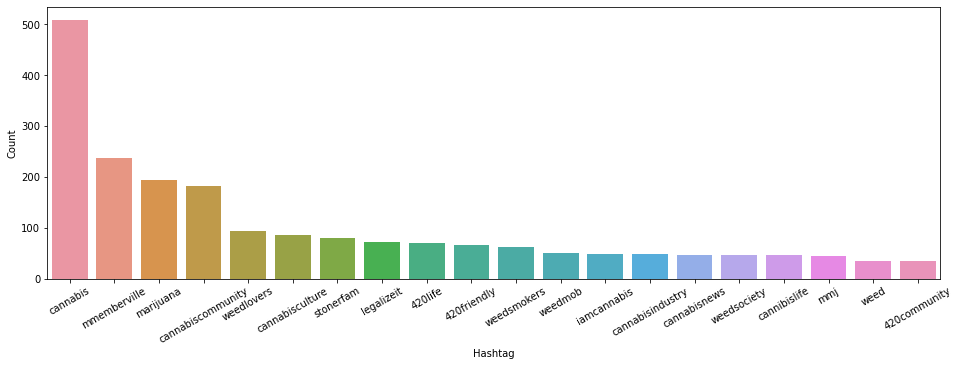

In [21]:
a = nltk.FreqDist(hashtag)
n_largest_hashtags = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_hashtags = n_largest_hashtags.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_hashtags, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=30)
plt.show()

In [22]:
#function to extract mentions from text
def mentions(x):
    # @x : text parameter to the function
    mentions = []
    for i in x:
        # re for finding mentions
        ht = re.findall(r'@[\w]*', i)
        # storing hashtags in list
        mentions.append(ht)
    # returns mentions from the function
    return mentions

In [23]:

#storing the mentions in list
mentions = mentions(tweetDf['Tweet'])

    # getting sum of the mentions
mentions = sum(mentions,[])


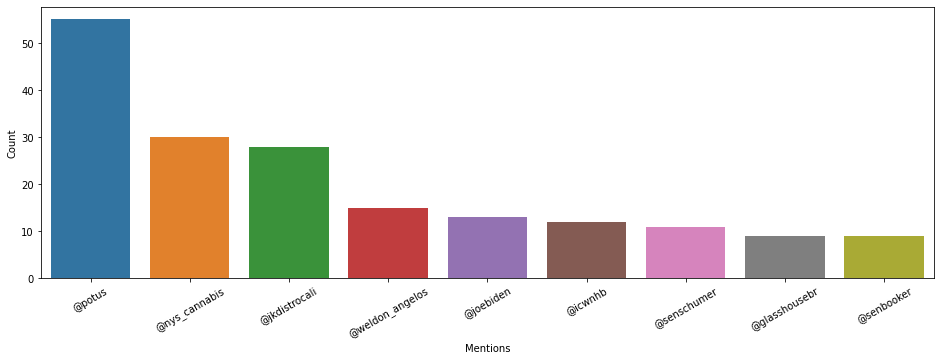

In [24]:
a = nltk.FreqDist(mentions)
n_largest_mentions = pd.DataFrame({'Mentions': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags    
n_largest_mentions = n_largest_mentions.nlargest(columns="Count", n = 10)
n_largest_mentions.drop(n_largest_mentions.index[n_largest_mentions['Mentions'] == '@'], inplace=True)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=n_largest_mentions, x= "Mentions", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=30)
plt.show()

In [25]:
clean_tweets = []   
for index, row in tweetDf.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Tweet.split() if 'http' not in word]
    clean_tweets.append(' '.join(words_without_links))

In [26]:
tweetDf['Tweet'] = clean_tweets

In [27]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

tweetDf['Tweet'] = np.vectorize(remove_pattern)(tweetDf['Tweet'], r"RT\s*:")


In [28]:
#creating the function to clean th text of tweets

def cleantextdata(text):

    # funtion to clean emojies
    def deEmojify(text):
        regrex_pattern = re.compile(pattern = "["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        u"\U00002500-\U00002BEF"  # Chinese char
                        u"\U00010000-\U0010ffff"
                               "]+", flags = re.UNICODE)
        return regrex_pattern.sub(r'',text)
    
    #removes all the mentions in the tweets
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    
    #removes  and replaces with '', if there are any characters with '@' character
    text = re.sub(r'@+','',text)
    #removes  and replaces with '', if there are any characters with '_' character
    text = re.sub(r'_*','',text)
    
    #removes  and replaces with '', if there are any characters with '.' character
    text = re.sub(r'/.+','',text)
    
    #removes all the hash tag in the tweet
    text = re.sub(r'#[A-Za-z0-9]+','',text)
    
    #removes next line character and replaces with ''
    text = re.sub(r'\n+',' ',text)
    
    #removes all the emojies from text replaces it with ''
    text = deEmojify(text)
    
    #removes all the pucntuations in the text replaces it with ''
    text = text.translate(str.maketrans('','',string.punctuation))
    
    #removes and replaces the extra space in the text with ''
    text = re.sub(r'^\s+|\s+$|\s+(?=\s)/g','',text)
    
    #removes and replaces the extra space in the text with ''
    text = re.sub(r'\s+',' ',text)
    
    #removes the space between words like ca nt, have nt and joins the words
    if " nt" in text:

        text = re.sub(r'\s+nt',"nt",text)
    #removes all the pucntuations in the text replaces it with ''
    text = text.translate(str.maketrans('','',string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [29]:
tweetDf['TweetCleaned'] = tweetDf['Tweet'].apply(cleantextdata)

In [30]:
stopwords_set = set(stopwords)
cleaned_tweets = []


for index, row in tweetDf.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.TweetCleaned.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweetDf['TweetCleaned'] = cleaned_tweets

In [31]:
tokenized_tweet = tweetDf['TweetCleaned'].apply(lambda x: x.split())

In [32]:
    
word_lemmatizer = WordNetLemmatizer()


tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

    
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)


tweetDf['TweetCleaned'] = tokenized_tweet

In [33]:
#creat a funtion to get subjectivity  and polarity

#if subjectivity is towards 1 that means its directed towards the topic
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#gives us the polarity of the tweet so that we can decide is it positive or negative tweet
def polarity(text):
    
    return TextBlob(text).sentiment.polarity

tweetDf['Subjectivity'] = tweetDf['TweetCleaned'].apply(subjectivity)
tweetDf['Polarity'] = tweetDf['TweetCleaned'].apply(polarity)

In [34]:
#creating a function to calculate and show the that tweet is negative or positive with the help of polarity

def analysis(score):
    
    #if polarity score is < 0 its a negative tweet
    if score < 0:
        return "Negative"
    #if polarity score is = 0 its a neutral tweet
    elif score == 0:
        return "Neutral"
    
    #if polarity score is > 0 its a Positive tweet
    else:
        return "Positive"

In [35]:
tweetDf['analysis'] = tweetDf['Polarity'].apply(analysis)

In [36]:
tweetDf['analysis'].value_counts()

Positive    1630
Neutral     1043
Negative     611
Name: analysis, dtype: int64

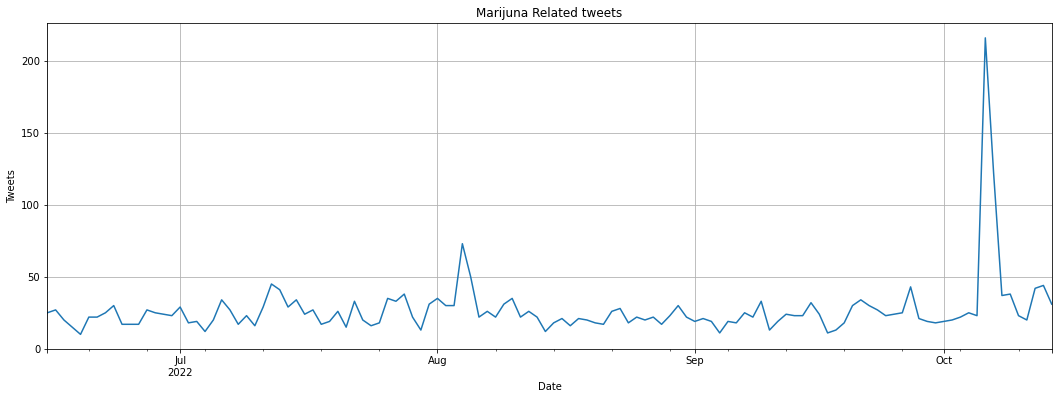

<Figure size 432x288 with 0 Axes>

In [37]:
#i am plotting the recent 1000 tweets which were made with  a frequency of 30 mins

#getting the data from the dataframe and grouping them at a frequency of 30 mins 
tweets = tweetDf.groupby(pd.Grouper(key='Date', freq='D', convention='start')).size()

# plot size 
tweets.plot(figsize=(18,6))

#X axis label
plt.xlabel('Date')
#y axis label
plt.ylabel('Tweets')

#title of the plot
plt.title('Marijuna Related tweets')
plt.grid(True)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("Marijuna_related_tweets_done_everyday.jpg", dpi=100)

In [38]:

#
# LDA parameters
#

# number of topics to discover (default = 10)
topicNum = 5
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1000



In [39]:
tweetDf

,Date,User,Tweet,Hashtags,Location,Mentioned User,Key Word,Reply Count,like Count,Retwet Count,Followers Count,TweetCleaned,Subjectivity,Polarity,analysis
0,2022-06-15 00:44:49+00:00,RobbinsGroupLLC,learn about terpinene terpinene is a minor #te...,"['terpene', 'cannabis', 'verbena']","Las Vegas, NV",no mentions,cannabis,0,5,1,12847,learn terpinene terpinene minor demonstrated a...,0.200000,-0.050000,Negative
1,2022-06-15 01:15:25+00:00,CPEARCoalition,great conversation with @repdavejoyce and cpea...,['cannabis'],"Washington, DC","[User(username='RepDaveJoyce', id=976969338, d...",cannabis,3,14,5,1544,great conversation cpear cochair conservative ...,0.507143,0.452381,Positive
2,2022-06-15 02:05:36+00:00,RobbinsGroupLLC,trending articles at @higherlvtm 👇🏽 &gt; canna...,no hashtags,"Las Vegas, NV","[User(username='HigherLvtm', id=12940090724007...",cannabis,0,2,2,12847,trending article gt cannabis multiple sclerosi...,0.000000,0.000000,Neutral
3,2022-06-15 02:17:42+00:00,mfjones69_,i been saying this since the day i got medical...,no hashtags,"Dallas, TX",no mentions,marijuana,0,8,5,992,saying since day got medical marijuana louisia...,0.625000,-0.333333,Negative
4,2022-06-15 02:56:53+00:00,eapenthampy,i spend a good deal of time starting rumors ab...,no hashtags,Currently in Missouri,no mentions,cannabis,0,3,0,3352,spend good deal time starting rumor cannabis p...,0.350000,0.350000,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279,2022-10-14 22:33:20+00:00,BikeLanesLA,california exceptionalism is living near more ...,no hashtags,"Los Angeles, CA",no mentions,cannabis,0,2,0,163,california exceptionalism living near cannabis...,0.400000,0.100000,Positive
3280,2022-10-14 22:40:56+00:00,levenson_scott,"as government ended alcohol prohibition,penalt...",['cannabis'],"New York, NY",no mentions,cannabis,0,3,0,1192,government ended alcohol prohibitionpenalties ...,0.244444,-0.005556,Negative
3281,2022-10-14 23:00:34+00:00,USMJParty,nbc news: oz says he supports biden on marijua...,no hashtags,USMjParty Cave City Kentucky,"[User(username='googlenews', id=33584794, disp...",marijuana,0,2,1,23751,nbc news oz say support biden marijuana pardon...,0.000000,0.000000,Neutral
3282,2022-10-14 23:04:07+00:00,RobbinsGroupLLC,🎧 like to listen &amp; learn? no small talk. a...,['cannabisindustry'],"Las Vegas, NV",no mentions,cannabis,0,12,5,12849,like listen amp learn small talk business cann...,0.266667,-0.016667,Negative


In [40]:
# Count Vectorizer
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(tweetDf['TweetCleaned'])
# extract the names of the features 
tfFeatureNames = tfVectorizer.get_feature_names()

#
# LDA MODEL
#
# Run LDA 
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [41]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.
    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """
    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [42]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
marijuana cannabis year people like medical day dispensary lot tax yall state look doesnt need
Topic 1:
cannabis pardon new right good patient come plant legalizing love time industry job check public
Topic 2:
marijuana state possession people federal biden legalization legal legalize simple vote recreational let say law
Topic 3:
cannabis marijuana amp prison use day week podcast biden charge drug gt level year world
Topic 4:
cannabis amp im want today great dont people weed know work make industry smoke big


In [43]:
panel = pyLDAvis.sklearn.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [44]:
usernameHAshtagAndLikes = list(zip(tweetDf['User'], tweetDf['Hashtags'], tweetDf['like Count']))
username = []
hashtag = []
likes=[]
for i,j,k in usernameHAshtagAndLikes:
    if j != 'no hashtags':
        
        for a in ast.literal_eval(j):
            username.append(i)
            hashtag.append(a)
            likes.append(k)
nodes = zip(username,hashtag,likes) 

In [45]:
zipped = list(zip(username, hashtag,likes))
nodes = pd.DataFrame(zipped, columns=['username', 'hashtag','likes'])

In [46]:
print(type(nodes))

<class 'pandas.core.frame.DataFrame'>


In [47]:
df1 = nodes['hashtag'].value_counts().iloc[:5].rename_axis('val').reset_index(name='count')

In [48]:
topTen = df1['val'].values.tolist()

In [49]:
topTen

['cannabis', 'mmemberville', 'marijuana', 'cannabiscommunity', 'weedlovers']

In [50]:
topTenValues = []
for i,j,k in zipped:
    
    if j in topTen:
        
        topTenValues.append((i,j,k))
        
        

In [51]:
nodesTen = pd.DataFrame(topTenValues, columns=['username', 'hashtag','likes'])

In [52]:
nodesTen['hashtag'].unique()

array(['cannabis', 'cannabiscommunity', 'mmemberville', 'marijuana',
       'weedlovers'], dtype=object)

In [53]:
import networkx as nx

from  matplotlib.pyplot import figure, text

In [54]:
G = nx.Graph()

In [55]:
G = nx.from_pandas_edgelist(nodesTen,'hashtag','username',edge_attr =True)


In [56]:
edgeList = nx.to_edgelist(G)

In [57]:
colors =[]

for node in G:
    
    if node in nodesTen['username'].values:
        colors.append("red")
    else:
        colors.append("yellow")

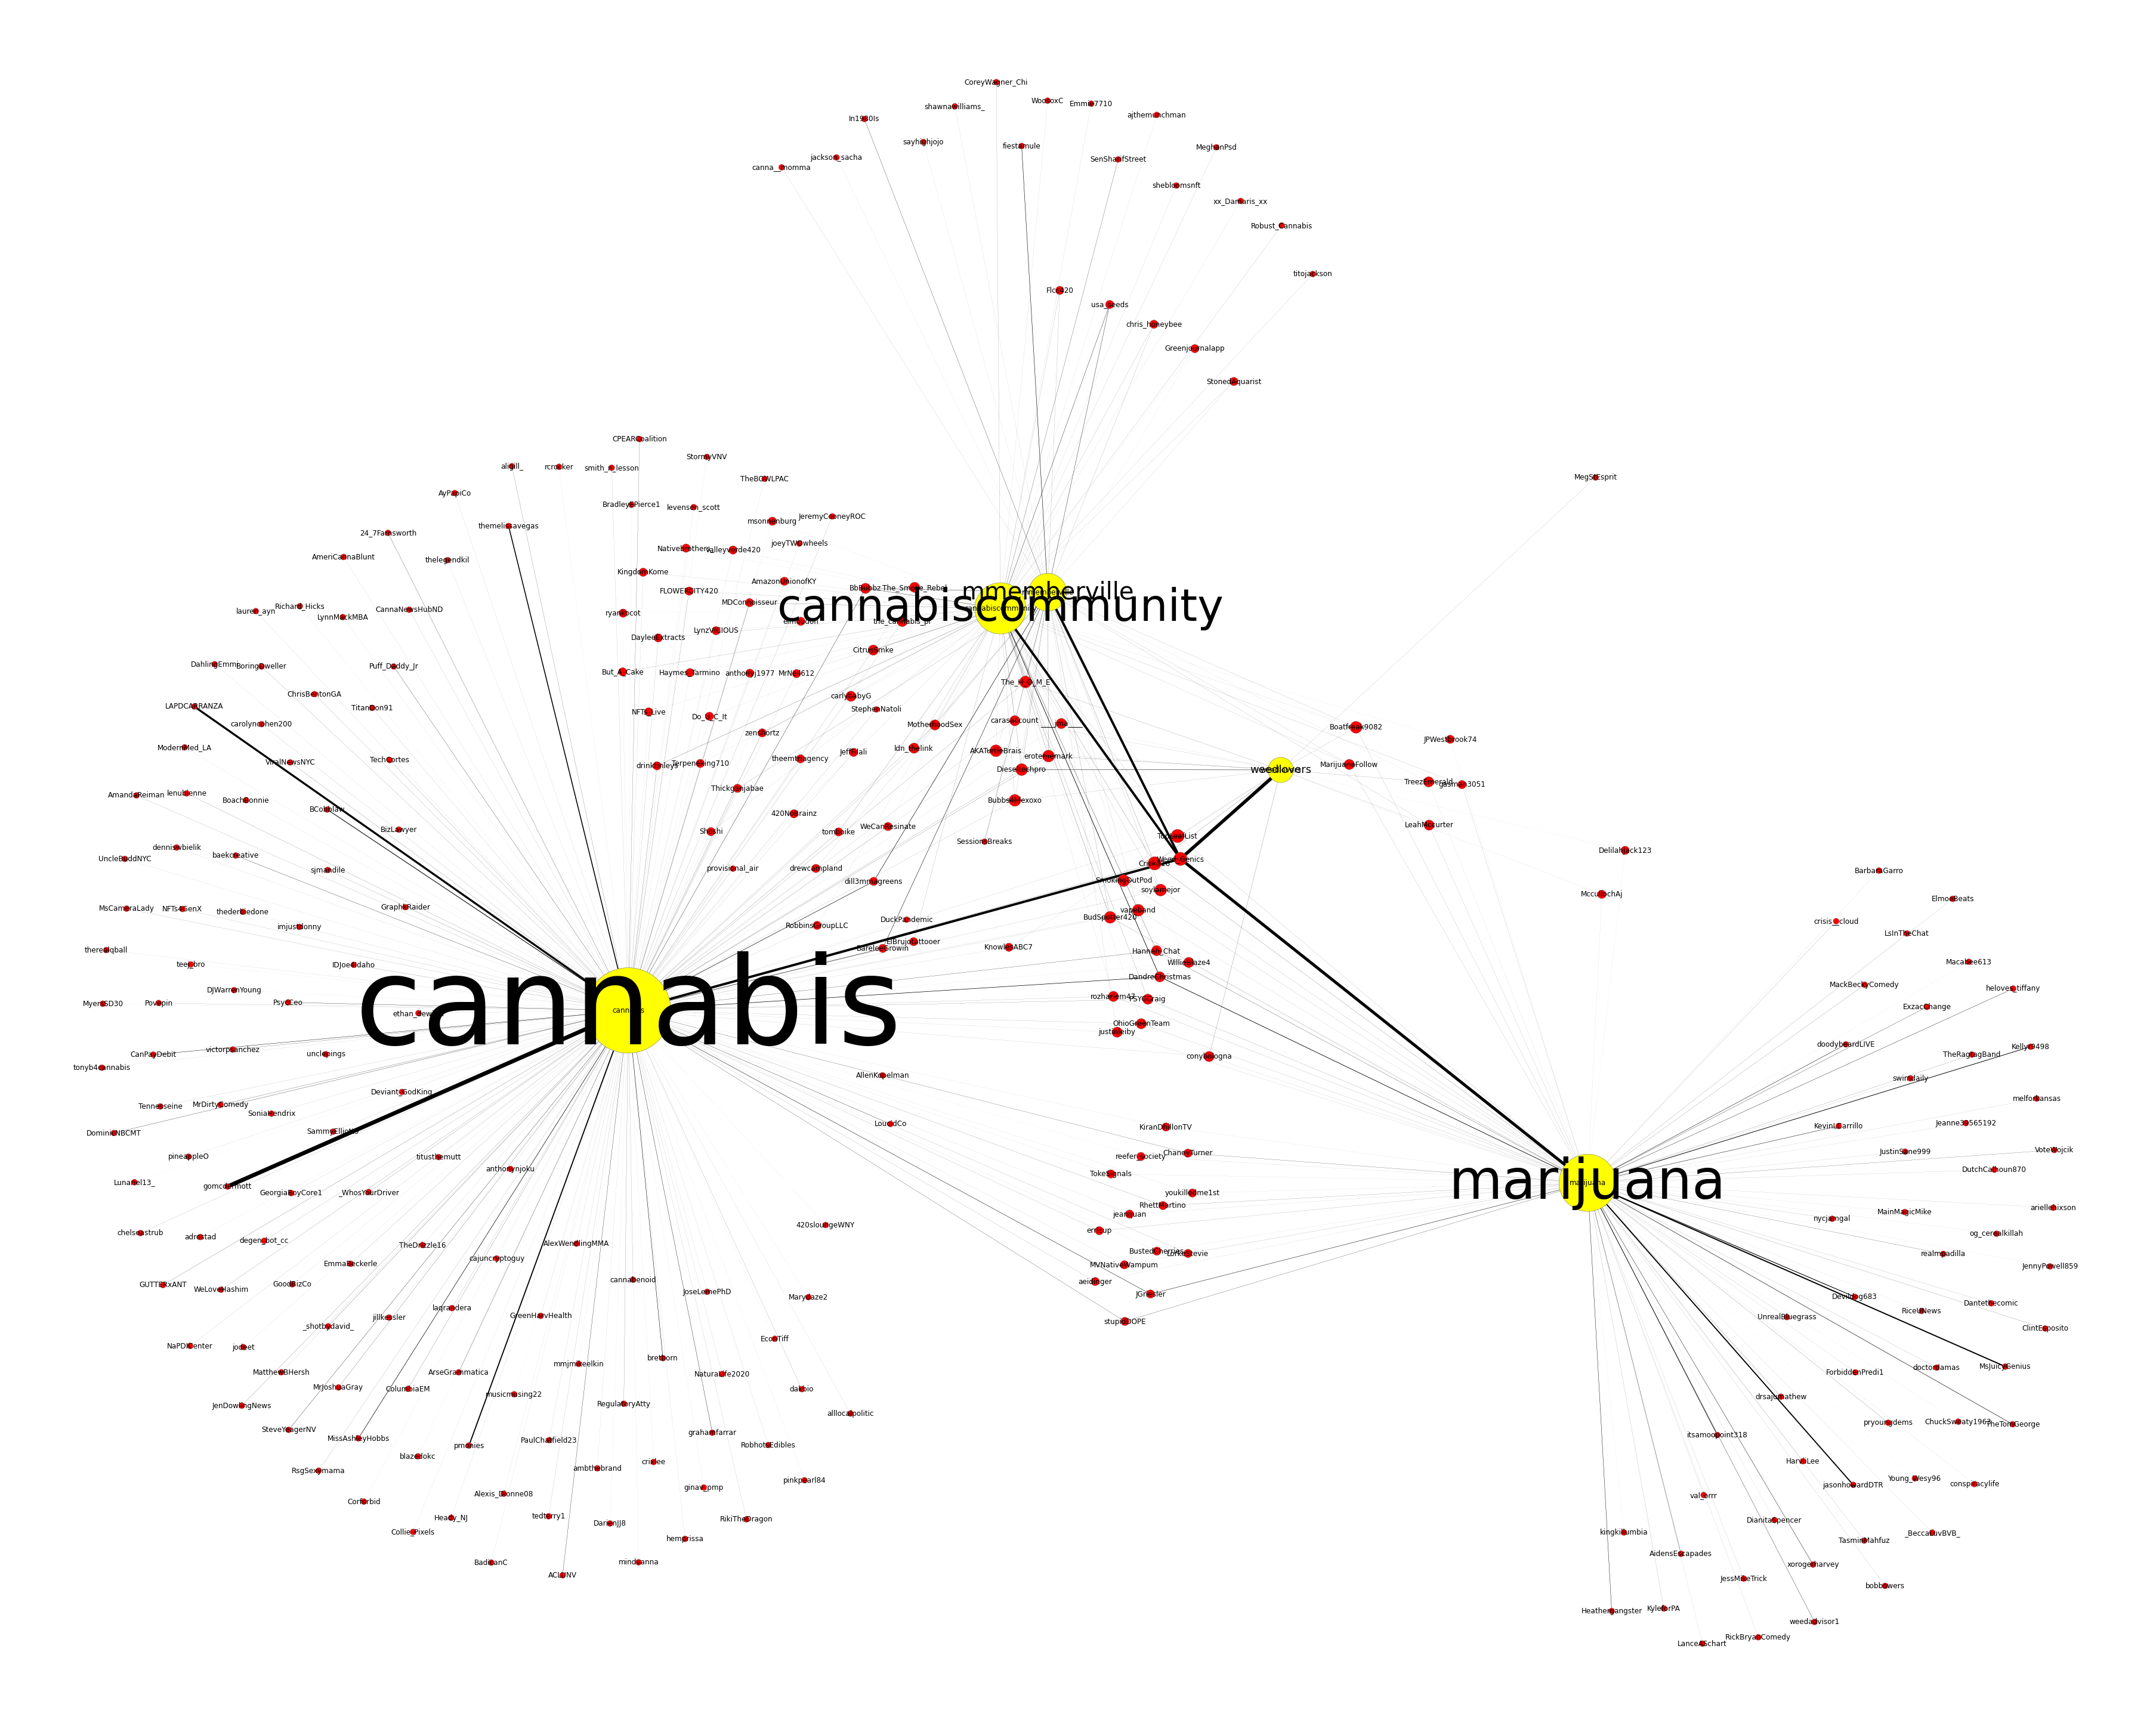

In [63]:
d= dict(G.degree)
pos = nx.spring_layout(G)
plt.figure(figsize=(50,40))
nx.draw(G, pos=pos,with_labels =True, node_color = colors,
        node_size = [ v * 100 for v in dict(G.degree()).values()]
       ,width =[v[2]['likes']/70 for v in edgeList])
for node,(x,y) in pos.items():
    text(x,y,node,fontsize= d[node], ha='center', va='center')

ax = plt.gca()
ax.collections[0].set_edgecolor("#696969")
plt.savefig("fig1.jpg", dpi=100)


In [59]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(200, 200))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,alpha=0.2)
nodes
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=50)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.1)

NameError: name 'pos' is not defined